In [5]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
import torch
from Models.CNN import CNN,Model_training,load_data,plot_metrics,evaluate_cnn_model
import re
import language_tool_python
from collections import Counter
from PIL import Image
from textblob import TextBlob
import cufflinks as cf
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from Prog.ModelEvaluator import ModelEvaluator
from Models.HARDVOTING_multi import HardVotingClassifier
from Models.XGBoost import XGBoostClassifier
from Models.KNN import KNNClassifier 
from imblearn.over_sampling import SMOTE
from Models.SVM import SVMClassifier
from Models.LSTM import LSTMClassifier
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from plotly import graph_objs as go
from collections import defaultdict
import pandas as pd
from plotly import tools
from plotly.offline import iplot
from palettable.colorbrewer.qualitative import Pastel1_7




In [6]:
from Preprocess.data_cleaning import DataCleaning
from Preprocess.data_visualisation import Data_visualisation
from Embeddings.Bert_Embeddings import BertEmbedding
from Embeddings.Deberta_embed import DebertaEmbedding
from Embeddings.Roberta_Embeddings import RobertaEmbedding

### Read data

In [3]:
df = pd.read_csv('C:/Users/iyadh/Desktop/hate_speech/Data/Ethos_Dataset_Multi_Label.csv', sep=';')

In [4]:
df.columns

Index(['comment', 'violence', 'directed_vs_generalized', 'gender', 'race',
       'national_origin', 'disability', 'religion', 'sexual_orientation'],
      dtype='object')

In [5]:
df.head(4)

,comment,violence,directed_vs_generalized,gender,race,national_origin,disability,religion,sexual_orientation
0,You should know women's sports are a joke,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0
1,You look like Sloth with deeper Down’s syndrome,0.000000,0.833333,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,You look like Russian and speak like Indian. B...,1.000000,0.500000,0.142857,0.142857,0.714286,0.0,0.0,0.0
3,"Women deserve to be abused, I guess.",0.666667,0.166667,1.000000,0.000000,0.000000,0.0,0.0,0.0


In [6]:
df.isnull().sum()

comment                    0
violence                   0
directed_vs_generalized    0
gender                     0
race                       0
national_origin            0
disability                 0
religion                   0
sexual_orientation         0
dtype: int64

In [7]:
df.shape

(433, 9)

### Preprocess data

In [8]:
# Create new DataFrame
df_fin = df[['comment']].copy()
cols = df.columns[1:]

# Get the column name with the maximum value
df_fin['class'] = df[cols].idxmax(axis=1)

In [9]:
df_fin.head(4)

,comment,class
0,You should know women's sports are a joke,gender
1,You look like Sloth with deeper Down’s syndrome,disability
2,You look like Russian and speak like Indian. B...,violence
3,"Women deserve to be abused, I guess.",gender


In [134]:
df_fin['class'].value_counts()

class
violence                   82
directed_vs_generalized    61
religion                   58
race                       58
gender                     48
sexual_orientation         45
national_origin            44
disability                 37
Name: count, dtype: int64

In [11]:
df_fin.isnull().sum()

comment    0
class      0
dtype: int64

## 2. Data Perprocessing

In [13]:
df_fin['cleaned_comment'] = df['comment'].apply(DataCleaning.preprocess_text)

In [ ]:
df_fin

,comment,class,cleaned_comment
0,You should know women's sports are a joke,gender,You should know women's sports are a joke
1,You look like Sloth with deeper Down’s syndrome,disability,You look like sloth with deeper downs syndrome
2,You look like Russian and speak like Indian. B...,violence,You look like Russian and speak like Indian bo...
3,"Women deserve to be abused, I guess.",gender,Women deserve to be abused I guess
4,Women are made for making babies and cooking d...,gender,Women are made for making babies and cooking d...
...,...,...,...
428,All people are fucked up because of these quee...,gender,All people are fucked up because of this queer...
429,Actually THIS WEIRD PEOPLE are HARMFUL! They n...,directed_vs_generalized,Actually this weird people are harmful they ne...
430,ABU DA BI ABA DU BA BA HAMUD! See? I’m an arab...,religion,Abu the bi ABA Du ba Hamid see I am an Arab pr...
431,a homo? so you fuck your brother instead of yo...,sexual_orientation,A homo so you fuck your brother instead of you...


# 4. Data augmentation
##### Since we dont have cuda were going to run in colab and u can find the notebooks in folder colab notebooks


# 5. Data modeling

In [37]:
# Encode target variable
le = LabelEncoder()
df_fin['class'] = le.fit_transform(df_fin['class'])

In [43]:
# Create a mapping dictionary
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for class_name, encoded_value in class_mapping.items():
    print(f"Class: {class_name}, Encoded Value: {encoded_value}")

Class: directed_vs_generalized, Encoded Value: 0
Class: disability, Encoded Value: 1
Class: gender, Encoded Value: 2
Class: national_origin, Encoded Value: 3
Class: race, Encoded Value: 4
Class: religion, Encoded Value: 5
Class: sexual_orientation, Encoded Value: 6
Class: violence, Encoded Value: 7


In [7]:
# Import generated data
df = pd.read_csv('./Data/type_of_hate_fin.csv')

## Bert embeddings

In [8]:
df = df[['cleaned_comment', 'class']]

In [9]:
df

,cleaned_comment,class
0,You should know women's sports are a joke,2
1,You look like sloth with deeper downs syndrome,1
2,You look like Russian and speak like Indian bo...,7
3,Women deserve to be abused I guess,2
4,Women are made for making babies and cooking d...,2
...,...,...
1727,You fuck your brother instead of your sister.,6
1728,"You want to fuck your brother, not your sister.",6
1729,They will be chased out of every white country...,4
1730,They will be chased out of every white country...,4


In [10]:
traindata,testdata=train_test_split(df,test_size=0.2,random_state=42)
print('Data shapes :',traindata.shape,testdata.shape)

Data shapes : (1385, 2) (347, 2)


In [11]:
train_comments = traindata['cleaned_comment'].values.tolist()
train_labels = traindata['class'].values.tolist()
test_comments = testdata['cleaned_comment'].values.tolist()
test_labels = testdata['class'].values.tolist()

train_comments, val_comments, train_labels, val_labels = train_test_split(train_comments, train_labels,
                                                                            test_size=0.1,random_state=42,stratify=train_labels)

In [12]:
print('Comments len :')
print('----')
print('train_comments',len(train_comments))
print('test_comments',len(test_comments))
print('valid_comments',len(val_comments))
print('----')

Comments len :
----
train_comments 1246
test_comments 347
valid_comments 139
----


In [13]:
# Instance of bert embeddings
BertEmbed=BertEmbedding(train_comments, test_comments, val_comments)

In [14]:
tokenizer, train_embeddings, val_embeddings, test_embeddings =  BertEmbed.generate_bert_embeddings()

In [16]:
#Create train dataframe
dfinter = []
for emb, label in zip(train_embeddings, train_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
traindata = pd.DataFrame(dfinter)
print(traindata.shape)
traindata.head(4)

(1246, 2)


,comment_embedding,label
0,"[-0.0076323026, 0.3019142, -0.616272, -0.17762...",2
1,"[-0.35173276, 0.18555248, -0.23085448, 0.17836...",1
2,"[-0.334541, -0.45035654, -0.8597468, 0.2097745...",3
3,"[0.1578814, 0.20769781, -0.3390271, 0.04229983...",6


In [17]:
#Create test dataframe
dfinter = []
for emb, label in zip(test_embeddings, test_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
testdata = pd.DataFrame(dfinter)
print(testdata.shape)
testdata.head(4)

(347, 2)


,comment_embedding,label
0,"[-0.047765754, 0.2645685, -0.5950049, -0.06015...",7
1,"[0.11265902, 0.18719116, -0.6417675, 0.3998339...",4
2,"[-0.42546603, 0.22952607, -1.100261, -0.047380...",7
3,"[0.5398975, 0.41006616, -0.16948217, 0.0512937...",4


In [18]:
#Create val dataframe
dfinter = []
for emb, label in zip(val_embeddings, val_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
valdata = pd.DataFrame(dfinter)
print(valdata.shape)
valdata.head(4)

(139, 2)


,comment_embedding,label
0,"[0.12540539, 0.12908763, 0.016268156, -0.09504...",1
1,"[-0.045072895, 0.46561813, -0.30640316, 0.2396...",4
2,"[0.32372954, 0.42845735, 0.22263497, -0.085201...",5
3,"[-0.116988614, 0.33750176, -0.56800735, -0.024...",6


### CNN

In [25]:
#Get data
train_data, val_data, test_data = load_data(traindata, valdata, testdata)

cnn_model = CNN(768,8)

# Entraînement du modèle
trainer = Model_training(cnn_model, train_data, val_data,epochs=20)
train_losses, val_losses, train_accuracies, val_accuracies = trainer.train()

Epoch [20/20], Train Loss: 0.3211, Val Loss: 0.9463, Train Acc: 0.9053, Val Acc: 0.7338


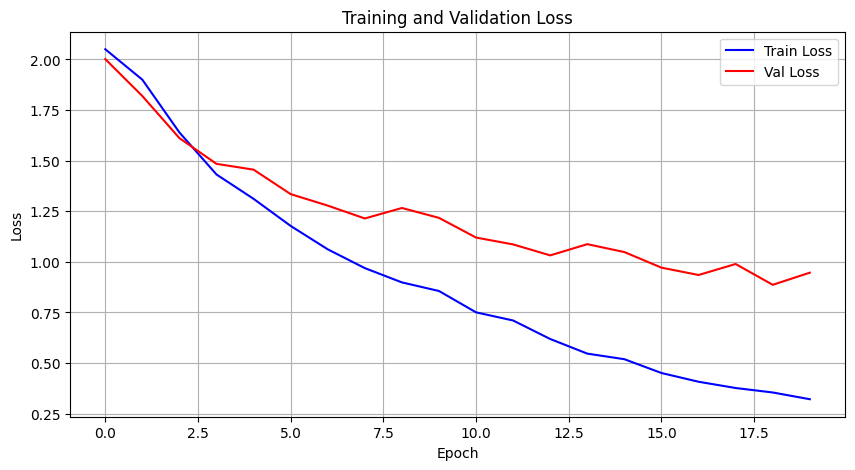

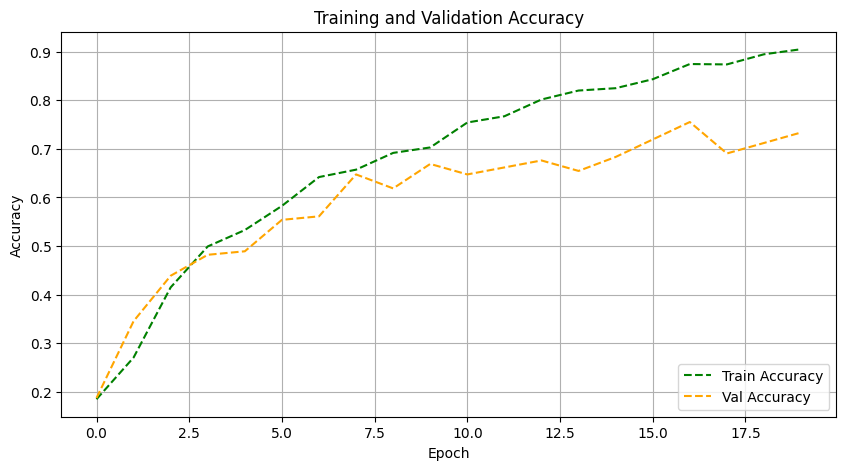

In [26]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

#### Training and Validation Metrics Summary

##### Loss
- *Training loss* decreases smoothly from 2.0 to ~0.25, showing effective learning.
- *Validation loss* drops from 2.0 to ~0.9 but fluctuates after epoch 10.
- Potential overfitting starts around epoch 10 due to the divergence.

##### Accuracy
- *Training accuracy* climbs steadily, reaching ~90%.
- *Validation accuracy* improves to ~80% but shows fluctuations after epoch 10.
- The gap between training and validation accuracy indicates mild overfitting.

##### Conclusion
- The CNN performs well but shows signs of overfitting after epoch 10. We may consider early stopping or regularization to improve generalization.

Accuracy 0.8040, Precision: 0.8325, Recall: 0.7998, F1-score: 0.8113

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82        52
           1       0.88      0.79      0.84        29
           2       0.86      0.89      0.88        36
           3       0.96      0.71      0.82        35
           4       0.76      0.87      0.81        39
           5       0.88      0.84      0.86        51
           6       0.82      0.68      0.74        34
           7       0.67      0.80      0.73        71

    accuracy                           0.80       347
   macro avg       0.83      0.80      0.81       347
weighted avg       0.82      0.80      0.81       347



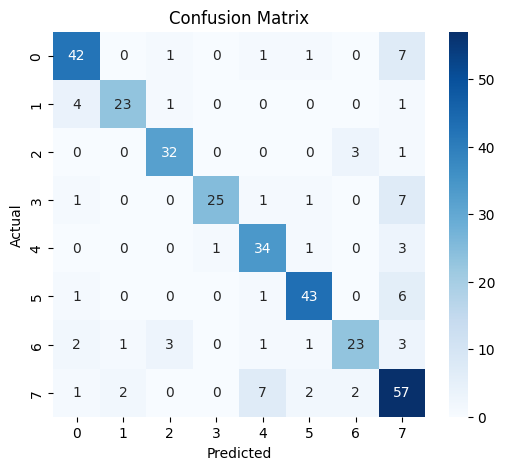

In [27]:
evaluate_cnn_model(cnn_model, test_data)

#### CNN Model Performance Analysis

##### Overview
- The CNN model achieved an accuracy of 0.8040, precision of 0.8325, recall of 0.7998, and an overall F1-score of 0.8113.

##### F1 Score per Class
- Class 0: 0.82
- Class 1: 0.84
- Class 2: 0.88
- Class 3: 0.82
- Class 4: 0.81
- Class 5: 0.86
- Class 6: 0.74
- Class 7: 0.73

##### F1 Score Observations
- Class 2 shows the highest F1 score (0.88), indicating strong performance.
- Classes 6 and 7 have the lowest F1 scores (0.74 and 0.73), suggesting areas for improvement.
- The model performs well across most classes, with some variability.

##### Confusion Matrix Analysis
###### Diagonal Values (Correct Predictions)
- Class 0: 42
- Class 1: 23
- Class 2: 32
- Class 3: 25
- Class 4: 34
- Class 5: 43
- Class 6: 23
- Class 7: 57

###### Misclassifications
- Class 0: 1 sample misclassified as Class 1, 1 as Class 3, 1 as Class 4, 7 as Class 7.
- Class 1: 4 samples misclassified as Class 0, 1 as Class 2, 1 as Class 7.
- Class 2: 3 samples misclassified as Class 6, 1 as Class 7.
- Class 3: 1 sample misclassified as Class 0, 1 as Class 4, 1 as Class 5, 7 as Class 7.
- Class 4: 1 sample misclassified as Class 3, 1 as Class 5, 3 as Class 7.
- Class 5: 1 sample misclassified as Class 0, 1 as Class 4, 1 as Class 6, 6 as Class 7.
- Class 6: 2 samples misclassified as Class 0, 1 as Class 1, 3 as Class 2, 1 as Class 4, 1 as Class 5, 3 as Class 7.
- Class 7: 2 samples misclassified as Class 0, 2 as Class 2, 2 as Class 3, 2 as Class 4, 2 as Class 5, 4 as Class 6.

###### Confusion Matrix Observations
- High correct predictions along the diagonal, with Class 7 (57) and Class 5 (43) performing best.
- Class 1 and Class 6 have the lowest correct predictions (23 each), with notable confusion across multiple classes.
- Class 7 is frequently involved in misclassifications (14 total), often confused with Class 0, while Class 3 is often misclassified as Class 7.

##### Conclusion
- The CNN model performs well with an overall F1-score of 0.8113, but struggles with Classes 6 and 7, as seen in their lower F1 scores (0.73–0.74) and frequent misclassifications. Improvements may be needed to address these issues.

## SVM

In [19]:
X_train = np.array(traindata['comment_embedding'].tolist())
y_train = np.array(traindata['label'])

X_val = np.array(valdata['comment_embedding'].tolist())
y_val = np.array(valdata['label'])

X_test = np.array(testdata['comment_embedding'].tolist())
y_test = np.array(testdata['label'])

In [20]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [21]:
# Instanciation de l'objet SVMClassifier
svm_model = SVMClassifier(kernel='linear')

In [23]:
# Train SVM model
svm_model.train_model(X_train_resampled,y_train_resampled)

# Predict on test set
y_pred = svm_model.predict_data(X_test)


In [24]:
# Vérifier les performances après l'entraînement
train_accuracy = svm_model.model.score(X_train_resampled, y_train_resampled)
val_accuracy = svm_model.model.score(X_val, y_val)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Train Accuracy: 1.0000
Validation Accuracy: 0.8058


Accuracy: 0.8617, Precision: 0.8660, Recall: 0.8787, F1-score: 0.8702

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        52
           1       0.90      0.93      0.92        29
           2       0.94      0.89      0.91        36
           3       0.85      0.97      0.91        35
           4       0.73      0.85      0.79        39
           5       0.92      0.88      0.90        51
           6       0.89      0.91      0.90        34
           7       0.88      0.73      0.80        71

    accuracy                           0.86       347
   macro avg       0.87      0.88      0.87       347
weighted avg       0.87      0.86      0.86       347



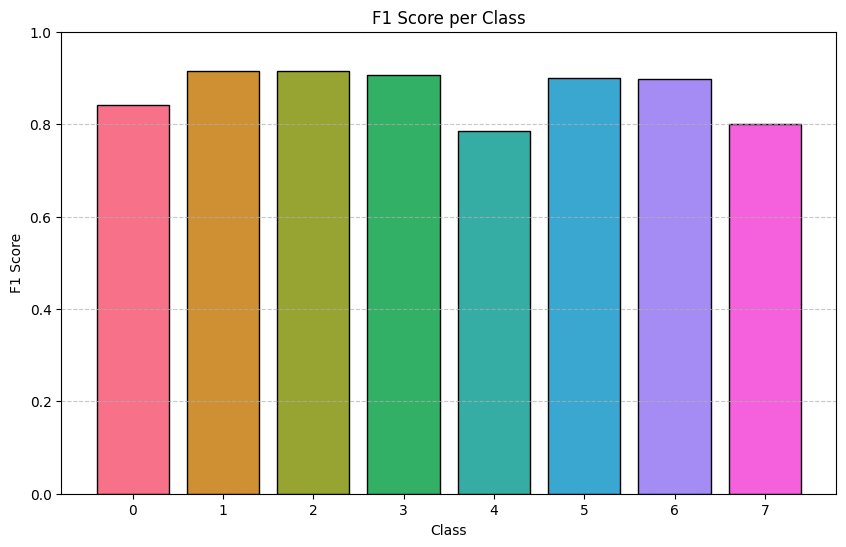

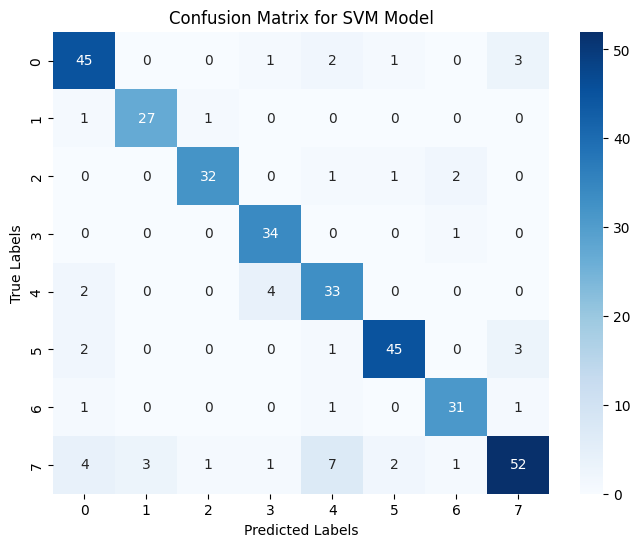

In [133]:
svm_model.evaluate_svm_model(X_test, y_test)

#### SVM Model Performance Analysis

##### Overview
- The SVM model achieved an accuracy of 0.8617, precision of 0.8660, recall of 0.8787, and an overall F1-score of 0.8702.

##### F1 Score per Class
- Class 0: ~0.84
- Class 1: ~0.92
- Class 2: ~0.91
- Class 3: ~0.91
- Class 4: ~0.79
- Class 5: ~0.90
- Class 6: ~0.90
- Class 7: ~0.80

##### F1 Score Observations
- Classes 1, 2, and 3 show the highest F1 scores (~0.91–0.92), indicating strong performance.
- Classes 4 and 7 have the lowest F1 scores (~0.79–0.80), suggesting potential areas for improvement.
- The model performs consistently well across most classes, with minor variations.

##### Confusion Matrix Analysis
###### Diagonal Values (Correct Predictions)
- Class 0: 45
- Class 1: 27
- Class 2: 32
- Class 3: 34
- Class 4: 33
- Class 5: 45
- Class 6: 31
- Class 7: 52

###### Misclassifications
- Class 0: 1 sample misclassified as Class 3, 2 as Class 4, 1 as Class 5, 3 as Class 7.
- Class 1: 1 sample misclassified as Class 2, 1 as Class 7.
- Class 2: 1 sample misclassified as Class 4, 1 as Class 5, 2 as Class 6.
- Class 3: 1 sample misclassified as Class 7.
- Class 4: 2 samples misclassified as Class 0, 4 as Class 3.
- Class 5: 1 sample misclassified as Class 4, 3 as Class 7.
- Class 6: 1 sample misclassified as Class 0, 1 as Class 4, 1 as Class 7.
- Class 7: 4 samples misclassified as Class 0, 3 as Class 1, 1 as Class 2, 1 as Class 3, 7 as Class 4, 2 as Class 5, 1 as Class 6.

###### Confusion Matrix Observations
- High correct predictions along the diagonal, with Class 7 (52) and Class 0 (45) performing best.
- Class 1 has the lowest correct predictions (27), with minor confusion toward Class 2 and Class 7.
- Class 7 shows the most misclassifications (19 total), often confused with Classes 0 and 4, aligning with its lower F1 score.

##### Conclusion
- The SVM model demonstrates robust performance across all classes, with an overall F1-score of 0.8702. However, Classes 4 and 7 show lower F1 scores (~0.79–0.80) and frequent misclassifications, particularly Class 7 being confused with Classes 0 and 4.

### KNN

In [90]:
knn_classifier = KNNClassifier(n_neighbors=3)

In [91]:
# Train KNN model
knn_classifier.train_model(X_train_resampled,y_train_resampled)


Accuracy: 0.7723, Precision: 0.7742, Recall: 0.7825, F1-score: 0.7734

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        52
           1       0.81      0.76      0.79        29
           2       0.69      0.94      0.80        36
           3       0.82      0.77      0.79        35
           4       0.79      0.79      0.79        39
           5       0.78      0.84      0.81        51
           6       0.69      0.74      0.71        34
           7       0.89      0.66      0.76        71

    accuracy                           0.77       347
   macro avg       0.77      0.78      0.77       347
weighted avg       0.78      0.77      0.77       347



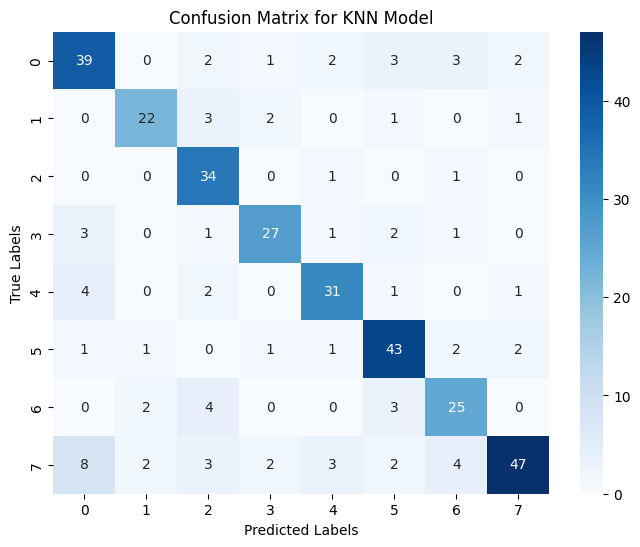

In [92]:
knn_classifier.evaluate_knn_model(X_test, y_test)

#### KNN Model Performance Analysis

##### Overview
- The KNN model achieved an accuracy of 0.7723, precision of 0.7742, recall of 0.7825, and an overall F1-score of 0.7734.

##### F1 Score per Class
- Class 0: 0.73
- Class 1: 0.79
- Class 2: 0.80
- Class 3: 0.79
- Class 4: 0.79
- Class 5: 0.81
- Class 6: 0.71
- Class 7: 0.76

##### F1 Score Observations
- Class 5 shows the highest F1 score (0.81), indicating strong performance.
- Class 6 has the lowest F1 score (0.71), suggesting room for improvement.
- The model performs moderately well across most classes, with some variability.

##### Confusion Matrix Analysis
###### Diagonal Values (Correct Predictions)
- Class 0: 39
- Class 1: 22
- Class 2: 34
- Class 3: 27
- Class 4: 31
- Class 5: 43
- Class 6: 25
- Class 7: 47

###### Misclassifications
- Class 0: 2 samples misclassified as Class 2, 1 as Class 3, 2 as Class 4, 3 as Class 5, 3 as Class 6, 2 as Class 7.
- Class 1: 3 samples misclassified as Class 2, 2 as Class 3, 1 as Class 5, 1 as Class 7.
- Class 2: 1 sample misclassified as Class 4, 1 as Class 6.
- Class 3: 3 samples misclassified as Class 0, 1 as Class 2, 1 as Class 4, 2 as Class 5, 1 as Class 6.
- Class 4: 4 samples misclassified as Class 0, 2 as Class 2, 1 as Class 5, 1 as Class 7.
- Class 5: 1 sample misclassified as Class 0, 1 as Class 1, 1 as Class 3, 1 as Class 4, 2 as Class 6, 2 as Class 7.
- Class 6: 2 samples misclassified as Class 1, 4 as Class 2, 3 as Class 5.
- Class 7: 8 samples misclassified as Class 0, 2 as Class 1, 3 as Class 2, 2 as Class 3, 3 as Class 4, 2 as Class 5, 4 as Class 6.

###### Confusion Matrix Observations
- High correct predictions along the diagonal, with Class 7 (47) and Class 5 (43) performing best.
- Class 1 and Class 6 have the lowest correct predictions (22 and 25), with notable confusion across multiple classes.
- Class 7 shows the most misclassifications (24 total), often confused with Classes 0, 2, and 6.

##### Conclusion
- The KNN model performs moderately well with an overall F1-score of 0.7734, but struggles with Classes 6 and 7, as seen in their lower F1 scores (0.71–0.76) and frequent misclassifications. Improvements may be needed to address these issues.

### Neural network

In [37]:
from Models.Neural_net import NeuralNetworkClassifier 

Accuracy: 0.8646, Precision: 0.8725, Recall: 0.8752, F1-score: 0.8713

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        52
           1       0.96      0.90      0.93        29
           2       0.94      0.92      0.93        36
           3       0.76      0.91      0.83        35
           4       0.77      0.92      0.84        39
           5       0.88      0.90      0.89        51
           6       0.91      0.85      0.88        34
           7       0.86      0.79      0.82        71

    accuracy                           0.86       347
   macro avg       0.87      0.88      0.87       347
weighted avg       0.87      0.86      0.87       347



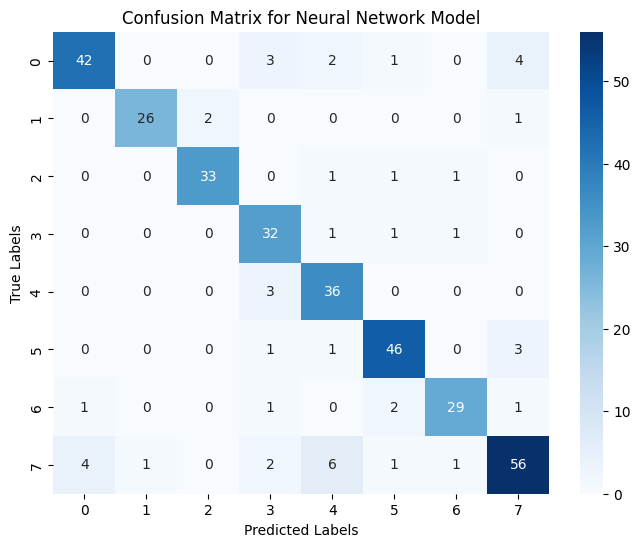

In [38]:
nn_classifier = NeuralNetworkClassifier(hidden_layer_sizes=(100,), max_iter=200, activation='relu')

# Train the model
nn_classifier.train_model(X_train_resampled, y_train_resampled)

# Evaluate the model
nn_classifier.evaluate_nn_model(X_test, y_test)

#### Confusion Matrix Analysis for Neural Network

##### Overview
- The confusion matrix represents the performance of the neural network across 8 classes, with an accuracy of 0.8646, precision of 0.8725, recall of 0.8752, and F1-score of 0.8713.

##### Diagonal Values (Correct Predictions)
- Class 0: 42
- Class 1: 26
- Class 2: 33
- Class 3: 32
- Class 4: 36
- Class 5: 46
- Class 6: 29
- Class 7: 56

##### Misclassifications
- Class 0: 3 samples misclassified as Class 3, 2 as Class 4, 1 as Class 5, 4 as Class 7.
- Class 1: 2 samples misclassified as Class 2, 1 as Class 7.
- Class 2: 1 sample misclassified as Class 4, 1 as Class 5, 1 as Class 6.
- Class 3: 1 sample misclassified as Class 4, 1 as Class 5, 1 as Class 6.
- Class 4: 3 samples misclassified as Class 3.
- Class 5: 1 sample misclassified as Class 3, 1 as Class 4, 3 as Class 7.
- Class 6: 1 sample misclassified as Class 0, 1 as Class 3, 2 as Class 5, 1 as Class 7.
- Class 7: 4 samples misclassified as Class 0, 1 as Class 1, 2 as Class 3, 6 as Class 4, 1 as Class 5, 1 as Class 6.

##### Observations
- High correct predictions along the diagonal, with Class 7 (56) and Class 5 (46) performing best.
- Class 1 has the lowest correct predictions (26), with some confusion toward Class 2.
- Class 7 shows the most misclassifications (15 total), often confused with Classes 0 and 4.

##### Conclusion
- The neural network performs well overall but shows confusion primarily involving Classes 0, 4, and 7, as seen in the misclassifications.

### Hard Voting

In [39]:
# Initialize the HardVotingClassifier with all five models
hard_voting_model = HardVotingClassifier(
    svm_model=svm_model,
    knn_model=knn_classifier,
    cnn_model=cnn_model,
    nn_model=nn_classifier
)

# Convert validation data to PyTorch tensor for CNN
val_inputs_tensor = torch.tensor(X_val, dtype=torch.float32)

# Perform predictions using the hard voting model
y_pred = hard_voting_model.predict(X_val, val_inputs_tensor)

# Evaluate the model performance (e.g., accuracy)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy of Hard Voting Classifier: {accuracy:.4f}')


Accuracy of Hard Voting Classifier: 0.8273


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        19
           1       1.00      0.83      0.91        12
           2       0.84      1.00      0.91        16
           3       0.80      0.86      0.83        14
           4       0.81      0.89      0.85        19
           5       0.83      0.83      0.83        18
           6       1.00      0.80      0.89        15
           7       0.76      0.73      0.75        26

    accuracy                           0.83       139
   macro avg       0.85      0.84      0.84       139
weighted avg       0.83      0.83      0.83       139


Confusion Matrix:


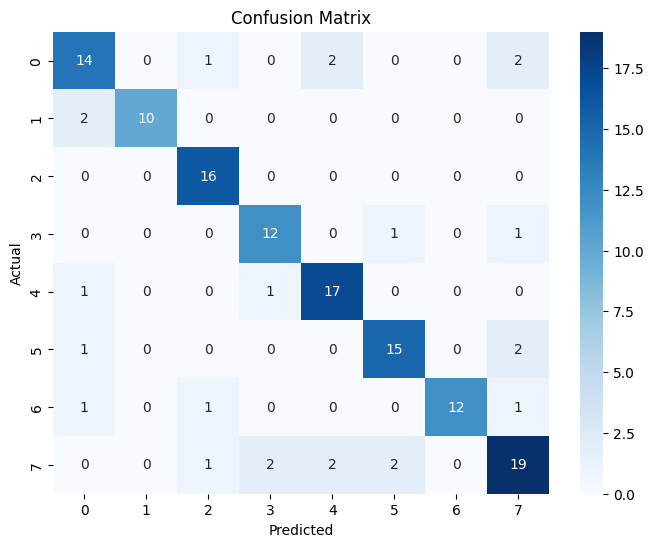

In [40]:
# Evaluate the model with the provided validation data
hard_voting_model.evaluate(X_val, val_inputs_tensor, y_val)

#### Hard Voting Confusion Matrix Analysis

##### Overview
- The confusion matrix represents the performance of the hard voting ensemble across 8 classes.

##### Diagonal Values (Correct Predictions)
- Class 0: 14
- Class 1: 10
- Class 2: 16
- Class 3: 12
- Class 4: 17
- Class 5: 15
- Class 6: 12
- Class 7: 19

##### Misclassifications
- Class 0: 2 samples misclassified as Class 4, 2 as Class 7.
- Class 1: 2 samples misclassified as Class 0.
- Class 3: 1 sample misclassified as Class 4, 1 as Class 7.
- Class 4: 1 sample misclassified as Class 0.
- Class 5: 1 sample misclassified as Class 0.
- Class 6: 1 sample misclassified as Class 0, 1 as Class 7.
- Class 7: 2 samples misclassified as Class 3, 2 as Class 4, 2 as Class 5.

##### Observations
- High correct predictions along the diagonal, with Class 7 (19) and Class 4 (17) performing best.
- Class 1 has the lowest correct predictions (10), with confusion toward Class 0.
- Classes 0, 4, and 7 show the most frequent misclassifications across other classes.

##### Conclusion
- The hard voting ensemble performs well but shows confusion primarily involving Classes 0, 4, and 7.

In [186]:
import joblib

# Save the model with joblib
joblib.dump(svm_model, 'model.pkl')


['model.pkl']

In [187]:
import pickle

# Save the tokenizer with pickle
with open("tokenizer_multi.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
